# Problem Statement

Sales forecasting is a crucial tool for retail organizations to develop strategies that align with demand and create promotions to enhance sales. Walmart, a billion-dollar American retail giant, operates over 10,000 stores worldwide and more than 4,000 across the United States (ref: https://corporate.walmart.com/about/location-facts). Accurate sales forecasting allows the company to manage inventory, predict revenue, and make informed decisions regarding new investments. Achieving predetermined targets early in the season can positively influence stock prices and shape investors' perceptions. On the other hand, missing these projections could significantly harm stock prices, which would be particularly detrimental for a large company like Walmart.

# Aim

The goal of this project is to develop a model that can forecast store sales based on past sales patterns. With this model, decision-makers can make critical business decisions, maximize revenue, and improve sales in underperforming departments.

# Data Exploration

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
# <== Importing Necessary Libraries ==>
import os
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# loading all datasets
df_features = pd.read_csv("/content/drive/MyDrive/Data/features.csv")
df_store = pd.read_csv("/content/drive/MyDrive/Data/stores.csv")
df_train = pd.read_csv("/content/drive/MyDrive/Data/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data/test.csv")

In [147]:
pd.options.display.max_rows=100
pd.pandas.set_option('display.max_columns', None)

### Dataset Description

1. **Features.csv**: Additional data related to the store, department, and regional activity for the given dates.
2. **train.csv**: This is the historical training data, which covers 2010–02–05 to 2012-08-17.
3. **test.csv**: Similar to train.csv, we've to predict weekly sales.
4. **stores.csv**: Contains anonymized information about the 45 stores, indicating the type and size of the store.

In [148]:
# lowercase all the column names and replace spaces with _
df_train.columns = df_train.columns.str.lower().str.replace(' ', '_')
df_store.columns = df_store.columns.str.lower().str.replace(' ', '_')
df_features.columns = df_features.columns.str.lower().str.replace(' ', '_')

### Exploring - Features.csv

In [149]:
print("Shape of dataset (rows x columns): ", df_features.shape)

Shape of dataset (rows x columns):  (8190, 12)


In [150]:
df_features.head(10)

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


In [151]:
df_features.head(-10)

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8175,45,2013-04-19,56.27,3.676,1399.81,39.89,44.38,60.83,1445.05,193.589304,8.335,False
8176,45,2013-04-26,50.64,3.615,1260.65,NaN,57.52,40.51,2476.18,193.589304,8.335,False
8177,45,2013-05-03,56.07,3.592,8345.40,6.00,92.96,3580.32,2242.24,NaN,NaN,False
8178,45,2013-05-10,58.86,3.583,4689.18,440.82,53.09,375.22,5738.20,NaN,NaN,False


In [152]:
# Display column names
print(df_features.columns)

Index(['store', 'date', 'temperature', 'fuel_price', 'markdown1', 'markdown2',
       'markdown3', 'markdown4', 'markdown5', 'cpi', 'unemployment',
       'isholiday'],
      dtype='object')


### Column wise description

- Store: Denotes the Store Number
- Date: Dates (Data) from 2010 - 2012
- Temperature: Temperature in Fahrenheit
- Fuel Price: Price of Fuel that day
- Markdown1, Markdown2, Markdown3, Markdown4: Anonymized data related to promotional markdowns at Walmart
- CPI: The consumer price index. It measures the monthly changes in prices paid by US consumers
- Unemployement: Rate of Unemployment
- IsHoliday: Is that particular day holiday or working day

In [153]:
# Display summary information about the dataset
print(df_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         8190 non-null   int64  
 1   date          8190 non-null   object 
 2   temperature   8190 non-null   float64
 3   fuel_price    8190 non-null   float64
 4   markdown1     4032 non-null   float64
 5   markdown2     2921 non-null   float64
 6   markdown3     3613 non-null   float64
 7   markdown4     3464 non-null   float64
 8   markdown5     4050 non-null   float64
 9   cpi           7605 non-null   float64
 10  unemployment  7605 non-null   float64
 11  isholiday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None


In [154]:
# Display statistical summary of the dataset
print(df_features.describe())

             store  temperature   fuel_price      markdown1      markdown2  \
count  8190.000000  8190.000000  8190.000000    4032.000000    2921.000000   
mean     23.000000    59.356198     3.405992    7032.371786    3384.176594   
std      12.987966    18.678607     0.431337    9262.747448    8793.583016   
min       1.000000    -7.290000     2.472000   -2781.450000    -265.760000   
25%      12.000000    45.902500     3.041000    1577.532500      68.880000   
50%      23.000000    60.710000     3.513000    4743.580000     364.570000   
75%      34.000000    73.880000     3.743000    8923.310000    2153.350000   
max      45.000000   101.950000     4.468000  103184.980000  104519.540000   

           markdown3     markdown4      markdown5          cpi  unemployment  
count    3613.000000   3464.000000    4050.000000  7605.000000   7605.000000  
mean     1760.100180   3292.935886    4132.216422   172.460809      7.826821  
std     11276.462208   6792.329861   13086.690278    39.7383

In [155]:
# Check for missing values
print(df_features.isnull().sum())

store              0
date               0
temperature        0
fuel_price         0
markdown1       4158
markdown2       5269
markdown3       4577
markdown4       4726
markdown5       4140
cpi              585
unemployment     585
isholiday          0
dtype: int64


In [156]:
# Number of unique values
df_features.nunique()

,0
store,45
date,182
temperature,4178
fuel_price,1011
markdown1,4023
markdown2,2715
markdown3,2885
markdown4,3405
markdown5,4045
cpi,2505


# Data Preprocessing

### Taking care of missing values

In [159]:
# filling missing values
df_features['cpi'].fillna(df_features['cpi'].median(),inplace=True)
df_features['unemployment'].fillna(df_features['unemployment'].median(),inplace=True)

/tmp/ipython-input-3803472090.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-3803472090.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

In [160]:
# replacing the markdown values with 0, as there is no information in the dataset on how these values are obtained and what they actually mean
for i in range(1, 6):
    df_features["markdown" + str(i)] = df_features["markdown" + str(i)].apply(lambda x: 0 if x < 0 else x)
    df_features["markdown" + str(i)].fillna(value=0, inplace=True)

/tmp/ipython-input-2139483102.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [161]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         8190 non-null   int64  
 1   date          8190 non-null   object 
 2   temperature   8190 non-null   float64
 3   fuel_price    8190 non-null   float64
 4   markdown1     8190 non-null   float64
 5   markdown2     8190 non-null   float64
 6   markdown3     8190 non-null   float64
 7   markdown4     8190 non-null   float64
 8   markdown5     8190 non-null   float64
 9   cpi           8190 non-null   float64
 10  unemployment  8190 non-null   float64
 11  isholiday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [162]:
df_features.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


In [163]:
df_train.shape, df_store.shape, df_features.shape

((421570, 5), (45, 3), (8190, 12))

### Merging DataFrames

Merging 3 dataframes:

1. `features.csv`: Description already provided above.

2. `train.csv`: This is the historical training data, which covers 2010–02–05 to 2012–11–01, with following fields:
    * `Store`: *The store number*
    * `Dept`: *The department number*
    * `Date`: *The week*
    * `Weekly_Sales`: *Sales for the given department in the given store*
    * `IsHoliday`: *Whether the week is a special holiday week*

3. `stores.csv`: This file contains anonymized information about the 45 stores, indicating the type and size of the store:
    * `Store`: *Stores numbered from 1 to 45*
    * `Type`: *Store type has been provided, there are 3 types — A, B and C*
    * `Size`: *Stores size has provided*

In [164]:
train_df = pd.merge(df_train,df_store,on='store',how='left')

In [165]:
train_df.head()

,store,dept,date,weekly_sales,isholiday,type,size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [166]:
df_features.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


In [167]:
print(df_features.columns)
print(df_train.columns)
print(df_store.columns)

Index(['store', 'date', 'temperature', 'fuel_price', 'markdown1', 'markdown2',
       'markdown3', 'markdown4', 'markdown5', 'cpi', 'unemployment',
       'isholiday'],
      dtype='object')
Index(['store', 'dept', 'date', 'weekly_sales', 'isholiday'], dtype='object')
Index(['store', 'type', 'size'], dtype='object')


### Ensuring Consistency in merged dataframe

In [168]:
# Convert store columns to string to ensure consistency
df_features['store'] = df_features['store'].astype(str)
df_train['store'] = df_train['store'].astype(str)
df_store['store'] = df_store['store'].astype(str)

# Convert date columns to datetime if they are not already
df_features['date'] = pd.to_datetime(df_features['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# Strip any leading/trailing spaces in the store columns
df_features['store'] = df_features['store'].str.strip()
df_train['store'] = df_train['store'].str.strip()
df_store['store'] = df_store['store'].str.strip()

In [169]:
# Merge df_features with df_train on 'store' and 'date'
merged_df = pd.merge(df_features, df_train, on=['store', 'date'], how='inner')

# Merge the result with df_stores on 'store' only
final_merged_df = pd.merge(merged_df, df_store, on='store', how='inner')

In [170]:
final_merged_df.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_x,dept,weekly_sales,isholiday_y,type,size
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,False,A,151315
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,False,A,151315
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,False,A,151315
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,False,A,151315
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,False,A,151315


In [171]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store         421570 non-null  object        
 1   date          421570 non-null  datetime64[ns]
 2   temperature   421570 non-null  float64       
 3   fuel_price    421570 non-null  float64       
 4   markdown1     421570 non-null  float64       
 5   markdown2     421570 non-null  float64       
 6   markdown3     421570 non-null  float64       
 7   markdown4     421570 non-null  float64       
 8   markdown5     421570 non-null  float64       
 9   cpi           421570 non-null  float64       
 10  unemployment  421570 non-null  float64       
 11  isholiday_x   421570 non-null  bool          
 12  dept          421570 non-null  int64         
 13  weekly_sales  421570 non-null  float64       
 14  isholiday_y   421570 non-null  bool          
 15  type          421

In [172]:
final_merged_df['date'] = pd.to_datetime(final_merged_df['date'],errors='coerce')
final_merged_df.sort_values(by=['date'],inplace=True)
final_merged_df.set_index(final_merged_df.date, inplace=True)
final_merged_df.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_x,dept,weekly_sales,isholiday_y,type,size
date,,,,,,,,,,,,,,,,,
2010-02-05,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,False,A,151315
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,False,3,14612.19,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,False,4,26323.15,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,False,5,36414.63,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,False,6,11437.81,False,B,103681


In [173]:
#checking whether the column IsHoliday_x and IsHoliday_y are same or not
final_merged_df['isholiday_x'].isin(final_merged_df['isholiday_y']).all()

np.True_

In [174]:
#Since these two columns are same so drop any one column and make another column as IsHoliday
final_merged_df.drop(columns='isholiday_x',inplace=True)
final_merged_df.rename(columns={"isholiday_y" : "IsHoliday"}, inplace=True)
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store         421570 non-null  object        
 1   date          421570 non-null  datetime64[ns]
 2   temperature   421570 non-null  float64       
 3   fuel_price    421570 non-null  float64       
 4   markdown1     421570 non-null  float64       
 5   markdown2     421570 non-null  float64       
 6   markdown3     421570 non-null  float64       
 7   markdown4     421570 non-null  float64       
 8   markdown5     421570 non-null  float64       
 9   cpi           421570 non-null  float64       
 10  unemployment  421570 non-null  float64       
 11  dept          421570 non-null  int64         
 12  weekly_sales  421570 non-null  float64       
 13  IsHoliday     421570 non-null  bool          
 14  type          421570 non-null  object        
 15  s

In [175]:
final_merged_df.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,dept,weekly_sales,IsHoliday,type,size
date,,,,,,,,,,,,,,,,
2010-02-05,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,24924.50,False,A,151315
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,3,14612.19,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,4,26323.15,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,5,36414.63,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,6,11437.81,False,B,103681


In [176]:
final_merged_df.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,dept,weekly_sales,IsHoliday,type,size
date,,,,,,,,,,,,,,,,
2010-02-05,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,24924.50,False,A,151315
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,3,14612.19,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,4,26323.15,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,5,36414.63,False,B,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,6,11437.81,False,B,103681


In [177]:
#Outlier Detection and Abnormalities
agg_data = final_merged_df.groupby(['store', 'dept']).weekly_sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
agg_data.head()

,store,dept,max,min,mean,median,std
0,1,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,1,2,65615.36,35819.83,46102.090420,45561.85,3440.673222
2,1,3,51159.17,6165.73,13150.478042,10366.85,8708.978853
3,1,4,47893.23,32497.43,36964.154476,36579.96,2930.698313
4,1,5,85676.09,11570.27,24257.941119,21183.42,11330.286495


In [178]:
agg_data.isnull().sum()

,0
store,0
dept,0
max,0
min,0
mean,0
median,0
std,37


In [179]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

final_merged_df['IsHoliday'] = le.fit_transform(final_merged_df['IsHoliday'])
final_merged_df['type'] = le.fit_transform(final_merged_df['type'])

In [180]:
final_merged_df.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,dept,weekly_sales,IsHoliday,type,size
date,,,,,,,,,,,,,,,,
2010-02-05,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,24924.50,0,0,151315
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,3,14612.19,0,1,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,4,26323.15,0,1,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,5,36414.63,0,1,103681
2010-02-05,35,2010-02-05,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,6,11437.81,0,1,103681


In [181]:
final_merged_df['dept'].nunique()

81

Note:

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some department numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81.

In [182]:
final_merged_df['IsHoliday'].nunique()

2

In [183]:
final_merged_df['type'].nunique()

3

### Plotting Stores by Weekly Sales

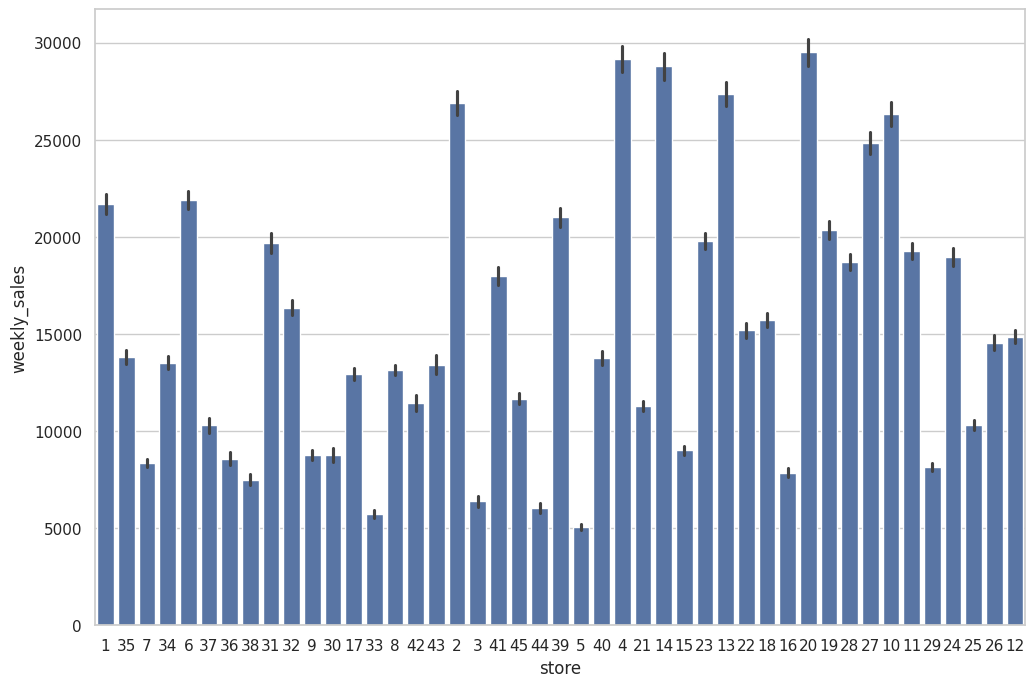

In [184]:
plt.figure(figsize=(12,8))
sns.barplot(x='store',y='weekly_sales',data=final_merged_df)
plt.show()

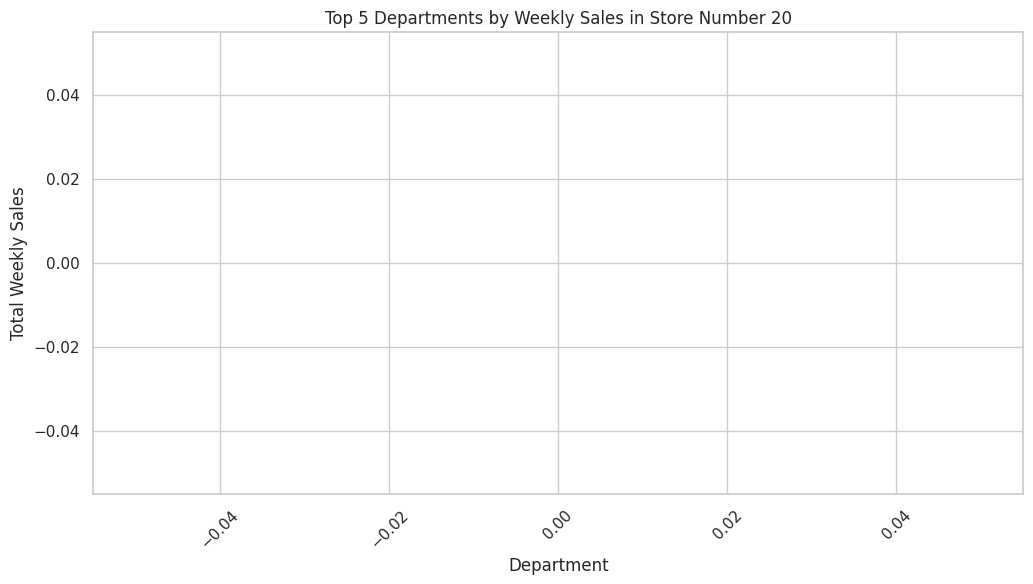

In [185]:
# <= Top 5 departments by weekly sales of Store 20 =>

# Filtering the DataFrame for store number 20
store_20_df = final_merged_df[final_merged_df['store'] == 20]

# Aggregating weekly sales by department
department_sales = store_20_df.groupby('dept')['weekly_sales'].sum().reset_index()

# Sorting departments by total sales and get the top 5 departments
top_departments = department_sales.sort_values(by='weekly_sales', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_departments['dept'].astype(str), top_departments['weekly_sales'])
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.title('Top 5 Departments by Weekly Sales in Store Number 20')
plt.xticks(rotation=45)
plt.show()

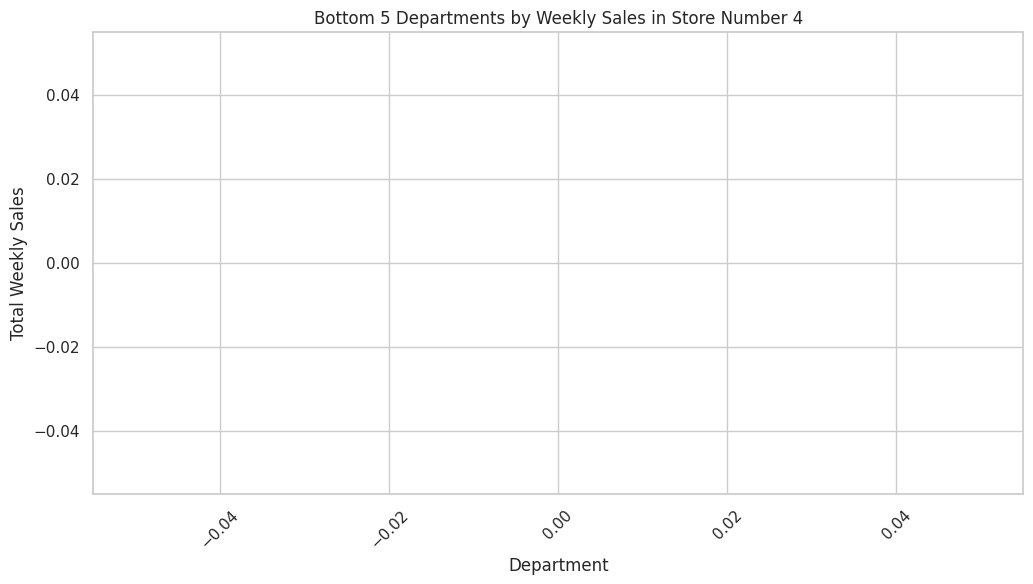

In [186]:
# <= Bottom 5 departments by weekly sales of Store 4 =>

# Filtering the DataFrame for store number 4
store_4_df = final_merged_df[final_merged_df['store'] == 4]

# Aggregating weekly sales by department
department_sales = store_4_df.groupby('dept')['weekly_sales'].sum().reset_index()

# Sorting departments by total sales and get the bottom 5
btm_departments = department_sales.sort_values(by='weekly_sales', ascending=True).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(btm_departments['dept'].astype(str), btm_departments['weekly_sales'])
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.title('Bottom 5 Departments by Weekly Sales in Store Number 4')
plt.xticks(rotation=45)
plt.show()

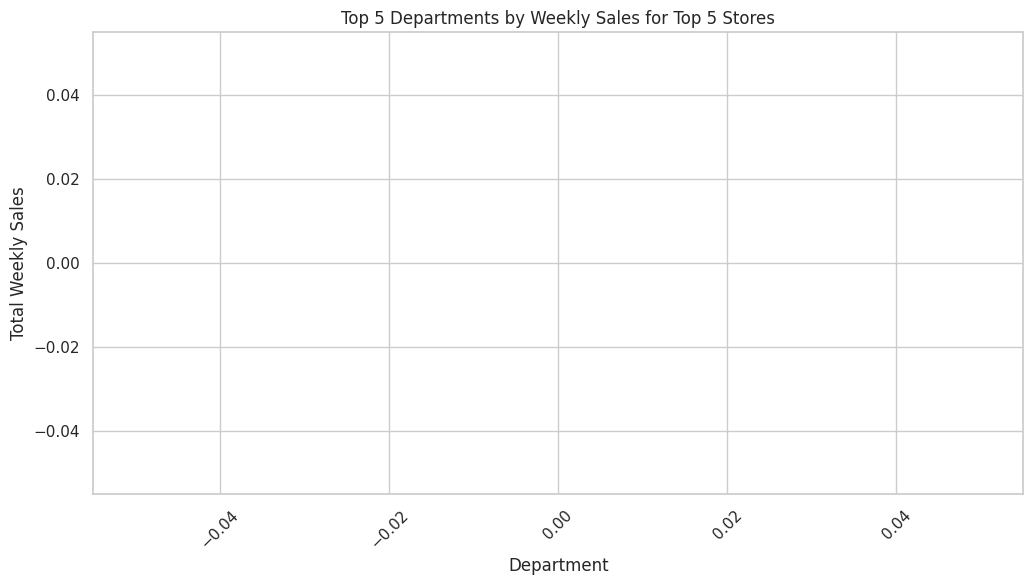

In [187]:
# <= Top 5 departments of Top 5 stores by weekly sales (Combined for entire duration) =>

# Define the top 5 stores
top_stores = [20, 4, 14, 13, 2]

# Filter the DataFrame for the top 5 stores
top_stores_df = final_merged_df[final_merged_df['store'].isin(top_stores)]

# Aggregating weekly sales by department
department_sales = top_stores_df.groupby('dept')['weekly_sales'].sum().reset_index()

# Sorting departments by total sales and get the top 5
top_departments = department_sales.sort_values(by='weekly_sales', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_departments['dept'].astype(str), top_departments['weekly_sales'])
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.title('Top 5 Departments by Weekly Sales for Top 5 Stores')
plt.xticks(rotation=45)
plt.show()

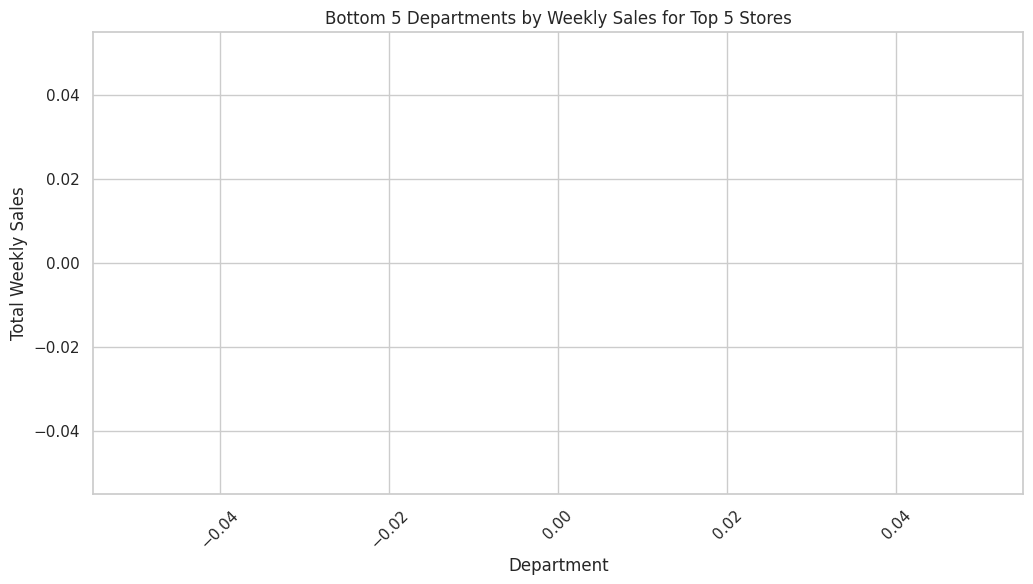

In [188]:
# <= Bottom 5 departments of Top 5 stores by weekly sales (Combined for entire duration) =>

# Define the top 5 stores
top_stores = [20, 4, 14, 13, 2]

# Filter the DataFrame for the top 5 stores
top_stores_df = final_merged_df[final_merged_df['store'].isin(top_stores)]

# Aggregating weekly sales by department
department_sales = top_stores_df.groupby('dept')['weekly_sales'].sum().reset_index()

# Sorting departments by total sales and get the bottom 5 department
btm_departments = department_sales.sort_values(by='weekly_sales', ascending=True).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(btm_departments['dept'].astype(str), btm_departments['weekly_sales'])
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.title('Bottom 5 Departments by Weekly Sales for Top 5 Stores')
plt.xticks(rotation=45)
plt.show()

In [189]:
data = pd.read_csv('/content/drive/MyDrive/Data/merged-data.csv')

In [190]:
data.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,dept,weekly_sales,IsHoliday,type,size
0,20,2010-02-05,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.19,1,46021.21,0,0,203742
1,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,17,198.01,0,2,42988
2,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,16,974.31,0,2,42988
3,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,14,1134.75,0,2,42988
4,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,13,12059.20,0,2,42988


In [191]:
# Convert the date column to datetime format if it's not already
data['date'] = pd.to_datetime(data['date'])

# Group by date and sum weekly sales
sales_over_time = data.groupby('date')['weekly_sales'].sum()

In [192]:
import plotly.graph_objects as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pd.options.plotting.backend= "plotly"

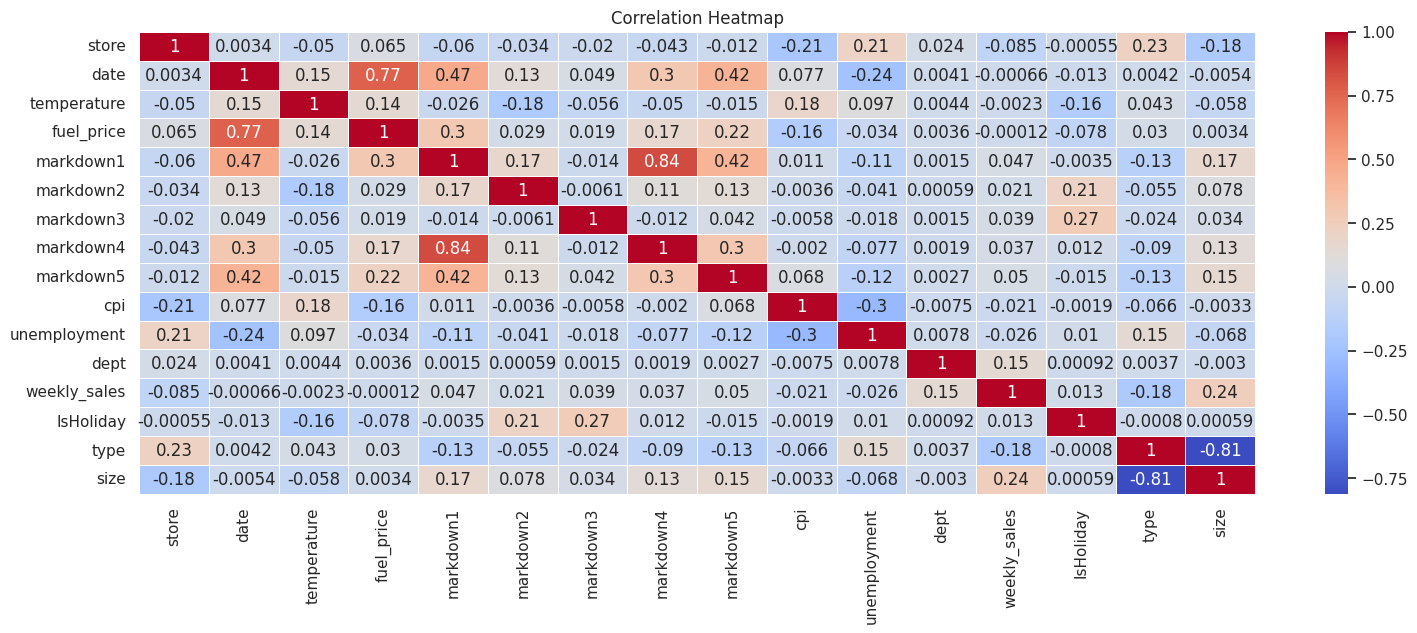

In [193]:
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

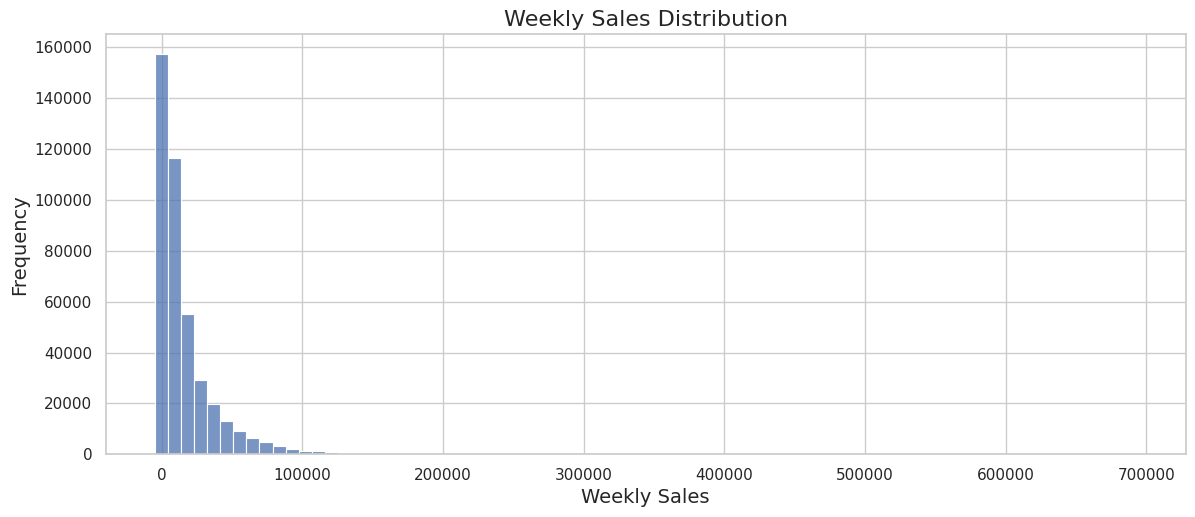

In [194]:
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the histogram with 75 bins
sns.histplot(data['weekly_sales'], bins=75, kde=False)

# Set the title and labels
plt.title('Weekly Sales Distribution', fontsize=16)
plt.xlabel('Weekly Sales', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Set margins
plt.gcf().subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.85)

# Show the plot
plt.show()

In [195]:
# average of weekly sales by department (sorted)
avg_sales_dept = data.groupby("dept")["weekly_sales"].mean().sort_values()

fig = go.Figure()

fig.add_trace(go.Bar(y=avg_sales_dept.values,
                    text=avg_sales_dept.index,
                     textposition='outside')
             )


fig.update_traces(marker_color='darkcyan',
                  marker_line_color='darkcyan',
                  marker_line_width=1.5,
                 )

fig.update_layout(title_text='Average Weekly Sales by Department',
                  xaxis_title_text="Department Number",   # xaxis label
                  xaxis_showticklabels=False,
                  yaxis_title_text="Average Sales") # yaxis label)


fig.show()

In [196]:
# average of weekly sales by store (sorted)
avg_sales_store = data.groupby("store")["weekly_sales"].mean().sort_values()
fig = go.Figure()

fig.add_trace(go.Bar(y=avg_sales_store.values,
                    text=avg_sales_store.index,
                     textposition='outside'))


fig.update_traces(marker_color='rosybrown',
                  marker_line_color='darkmagenta',
                  marker_line_width=1.5,)

fig.update_layout(title_text='Average Weekly Sales by Store',
                  xaxis=dict(
                      title_text="Store Number",
                      showticklabels=False,
                      ticks='outside',
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)')),
                       yaxis=dict(
                             title_text="Average Sales"))

fig.show()

In [197]:
# checking out the sum of sales by store type
fig = go.Figure()

fig.add_trace(go.Histogram(x=data["type"],
                          histnorm="percent",
                           xbins=dict(size=0.5),marker_color='#EB89B5',opacity=0.75))

fig.update_layout(
    height=500, width=400,
    title_text="Store Types in %",
    xaxis_title_text="Type",
    yaxis_title_text="Ratio",
)

fig.show()

Note: Some department numbers are missing

- Top 5 Departments:
1. 92: Dry Grocery
2. 95: Grocery, Snacks, and Beverages
3. 90: Dairy
4. 38: Prescription Pharmacy
5. 72: Electronics

- Bottom 5 Departments:

1. 43: Toys (Unsual)
2. 39: Misc/Jewellery
3. 78: Ladieswear (Part of Fashion)
4. 47: Something in Fashion
5. 51: Sporting Goods

# Modelling

In [198]:
data = pd.read_csv('/content/drive/MyDrive/Data/merged-data.csv')

In [199]:
# Converting the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extracting year, month, and week from the date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week

# Checking for missing values
missing_values = data.isnull().sum()

# Displaying the updated dataset with new features and missing values
data.head()


,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,dept,weekly_sales,IsHoliday,type,size,year,month,week
0,20,2010-02-05,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.19,1,46021.21,0,0,203742,2010,2,5
1,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,17,198.01,0,2,42988,2010,2,5
2,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,16,974.31,0,2,42988,2010,2,5
3,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,14,1134.75,0,2,42988,2010,2,5
4,30,2010-02-05,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.32,13,12059.20,0,2,42988,2010,2,5


In [200]:
missing_values

,0
store,0
date,0
temperature,0
fuel_price,0
markdown1,0
markdown2,0
markdown3,0
markdown4,0
markdown5,0
cpi,0


In [201]:
from sklearn.model_selection import train_test_split

# Select the features for the model (excluding the target variable 'weekly_sales' and 'date')
features = data.drop(columns=['weekly_sales', 'date'])

# Target variable
target = data['weekly_sales']

In [202]:
features.columns

Index(['store', 'temperature', 'fuel_price', 'markdown1', 'markdown2',
       'markdown3', 'markdown4', 'markdown5', 'cpi', 'unemployment', 'dept',
       'IsHoliday', 'type', 'size', 'year', 'month', 'week'],
      dtype='object')

In [203]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [204]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_score(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = model.predict(X_train)
        print("Train Result:\n================================================")
    else:
        pred = model.predict(X_test)
        print("Test Result:\n================================================")

    mae = mean_absolute_error(y_train if train else y_test, pred)
    mse = mean_squared_error(y_train if train else y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train if train else y_test, pred)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print("================================================\n")


## Linear Models

In [205]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# 1. Define model
lr = LinearRegression()

# 2. Define parameter grid
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# 3. Setup GridSearchCV
grid_search = GridSearchCV(estimator=lr,
                           param_grid=param_grid,
                           cv=5,          # 5-fold cross validation
                           scoring='r2', # metric for selection
                           n_jobs=-1)

# 4. Fit model
grid_search.fit(X_train, y_train)

# 5. Best model
best_lr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# 6. Evaluate with your function
print_score(best_lr, X_train, y_train, X_test, y_test, train=True)
print_score(best_lr, X_train, y_train, X_test, y_test, train=False)


Best Parameters: {'fit_intercept': True, 'positive': False}
Train Result:
MAE: 14533.5137
MSE: 470663081.1054
RMSE: 21694.7708
R²: 0.0876

Test Result:
MAE: 14589.8011
MSE: 470345208.5756
RMSE: 21687.4436
R²: 0.0878



Note: As anticipated, Linear Regression does not yield good results because the data does not exhibit a linear relationship.

### Tree

In [206]:
from sklearn.ensemble import RandomForestRegressor

# 1. Define the model with some good default parameters
rf = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=15,          # limit depth to avoid overfitting
    min_samples_split=5,   # minimum samples to split a node
    min_samples_leaf=2,    # minimum samples per leaf
    max_features='sqrt',   # number of features to consider at split
    random_state=42,
    n_jobs=-1
)

# 2. Train model
rf.fit(X_train, y_train)

# 3. Evaluate using your function
print_score(rf, X_train, y_train, X_test, y_test, train=True)
print_score(rf, X_train, y_train, X_test, y_test, train=False)


Train Result:
MAE: 7448.4240
MSE: 132281121.7910
RMSE: 11501.3530
R²: 0.7436

Test Result:
MAE: 8034.9596
MSE: 160716950.7191
RMSE: 12677.4189
R²: 0.6883



### XGB Regressor

In [207]:
from xgboost import XGBRegressor

# 1. Define the model with common good defaults
xgb = XGBRegressor(
    n_estimators=300,       # number of boosting rounds
    learning_rate=0.1,      # step size shrinkage
    max_depth=6,            # depth of each tree
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

# 2. Train the model
xgb.fit(X_train, y_train)

# 3. Evaluate with your function
print_score(xgb, X_train, y_train, X_test, y_test, train=True)
print_score(xgb, X_train, y_train, X_test, y_test, train=False)


Train Result:
MAE: 3063.0883
MSE: 29045675.5938
RMSE: 5389.4040
R²: 0.9437

Test Result:
MAE: 3161.7638
MSE: 31839087.2424
RMSE: 5642.6135
R²: 0.9383



# Forecasting : ARIMA, Modified ARIMA, SARIMA

## ARIMA

In [208]:
from statsmodels.tsa.arima.model import ARIMA

In [209]:
data['date'] = pd.to_datetime(data['date'])

# Aggregate the data by week
weekly_sales = data.groupby('date')['weekly_sales'].sum().reset_index()

# Set the date as the index
weekly_sales.set_index('date', inplace=True)

In [210]:
# Define the training period
train = weekly_sales.iloc[:-52]  # Use all but the last year for training
test = weekly_sales.iloc[-52:]   # Use the last year for testing

In [211]:
# Fit the ARIMA model
model = ARIMA(train, order=(5,1,0))  # (p,d,q) parameters can be tuned
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



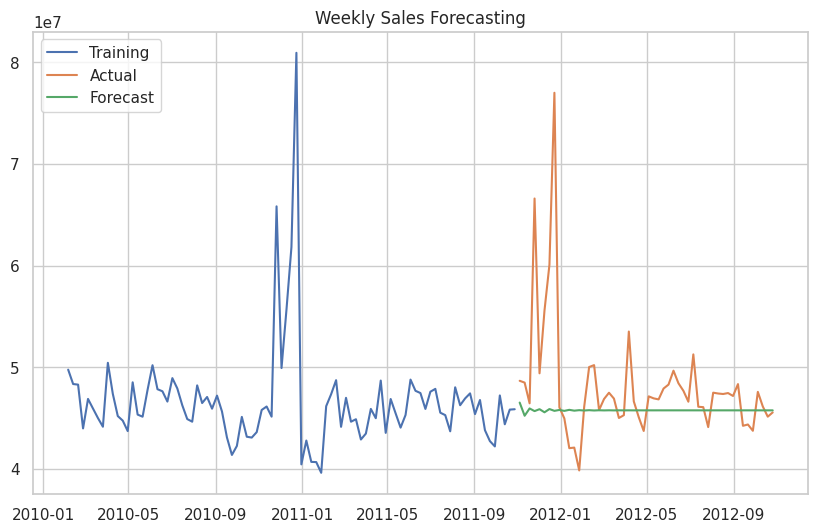

In [212]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Plot the forecast against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('Weekly Sales Forecasting')
plt.show()

## Tuning ARIMA Model

In [213]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

data['date'] = pd.to_datetime(data['date'])

# Aggregate the data by week
weekly_sales = data.groupby('date')['weekly_sales'].sum().reset_index()

# Set the date as the index
weekly_sales.set_index('date', inplace=True)

# Define the training period
train = weekly_sales.iloc[:-52]  # Use all but the last year for training
test = weekly_sales.iloc[-52:]   # Use the last year for testing

# Grid search for ARIMA parameters
best_aic = np.inf
best_order = None
best_model = None

# Define a range of p, d, q values to try
p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception as e:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

# Use the best model for predictions
predictions = best_model.forecast(steps=len(test))

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"RMSE for best ARIMA model: {rmse}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information w

Best ARIMA order: (0, 1, 5) with AIC: 3050.9341382069683
RMSE for best ARIMA model: 6263405.3719852185


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



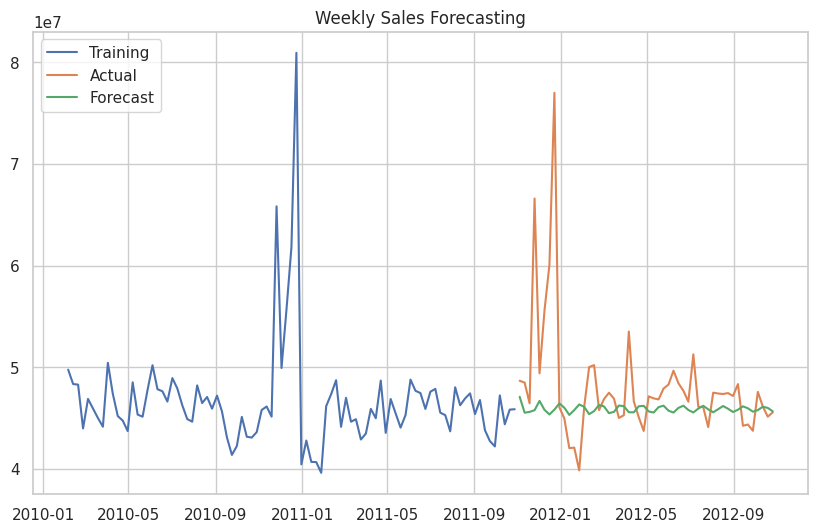

In [214]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Plot the forecast against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('Weekly Sales Forecasting')
plt.show()

## SARIMA

In [215]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Preprocess
data['date'] = pd.to_datetime(data['date'])
weekly_sales = data.groupby('date')['weekly_sales'].sum().reset_index()
weekly_sales.set_index('date', inplace=True)

# Train-test split (last 52 weeks = test)
train = weekly_sales.iloc[:-52]
test = weekly_sales.iloc[-52:]

# Instead of full grid search, just try a few reasonable options
order = (1, 1, 1)                # ARIMA part
seasonal_order = (1, 1, 1, 52)   # SARIMA part (weekly seasonality)

# Fit once on training data
model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast the entire test set in one go (faster than walk-forward)
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f"Simplified SARIMA RMSE: {rmse:.2f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Simplified SARIMA RMSE: 1912299.01


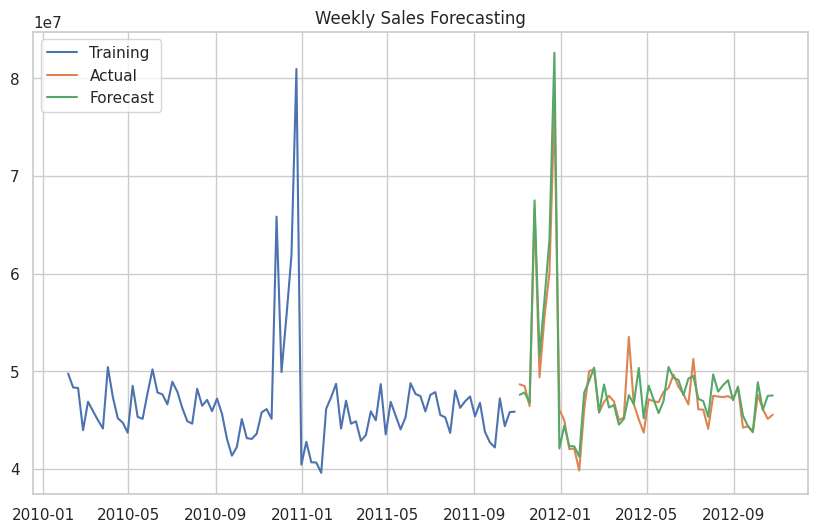

In [216]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Plot the forecast against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('Weekly Sales Forecasting')
plt.show()

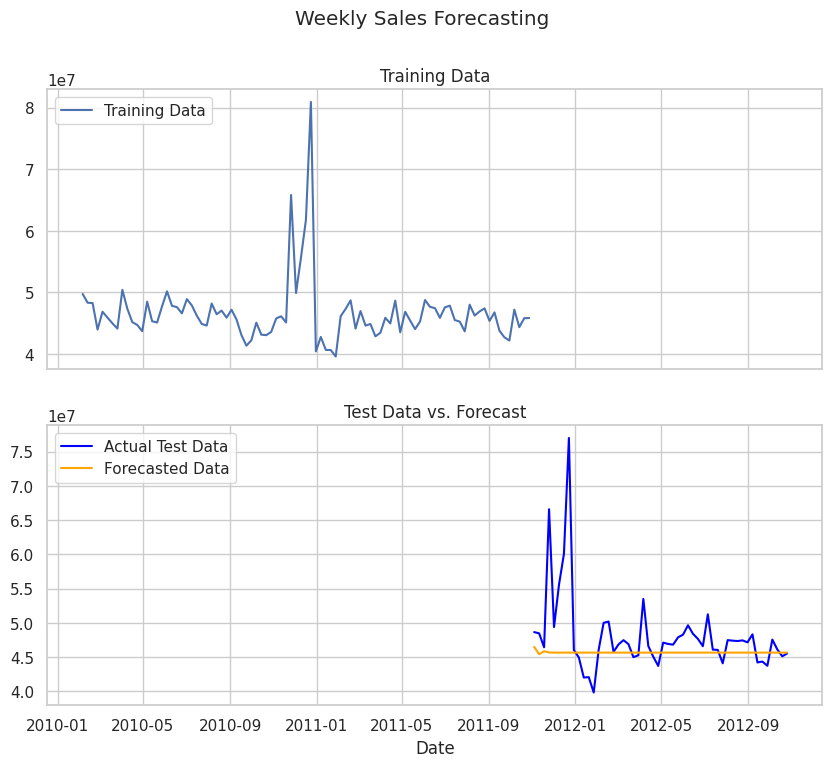

In [217]:
import matplotlib.pyplot as plt

# Forecast for the test period
forecast = best_model.forecast(steps=len(test))

# Plot the training and test data with forecasts in two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Upper subplot for training data
ax1.plot(train.index, train, label='Training Data')
ax1.set_title('Training Data')
ax1.legend(loc='upper left')

# Lower subplot for test data and forecasts
ax2.plot(test.index, test, label='Actual Test Data', color='blue')
ax2.plot(test.index, forecast, label='Forecasted Data', color='orange')
ax2.set_title('Test Data vs. Forecast')
ax2.legend(loc='upper left')

# Set common x-axis label and overall title
fig.suptitle('Weekly Sales Forecasting')
plt.xlabel('Date')
plt.show()

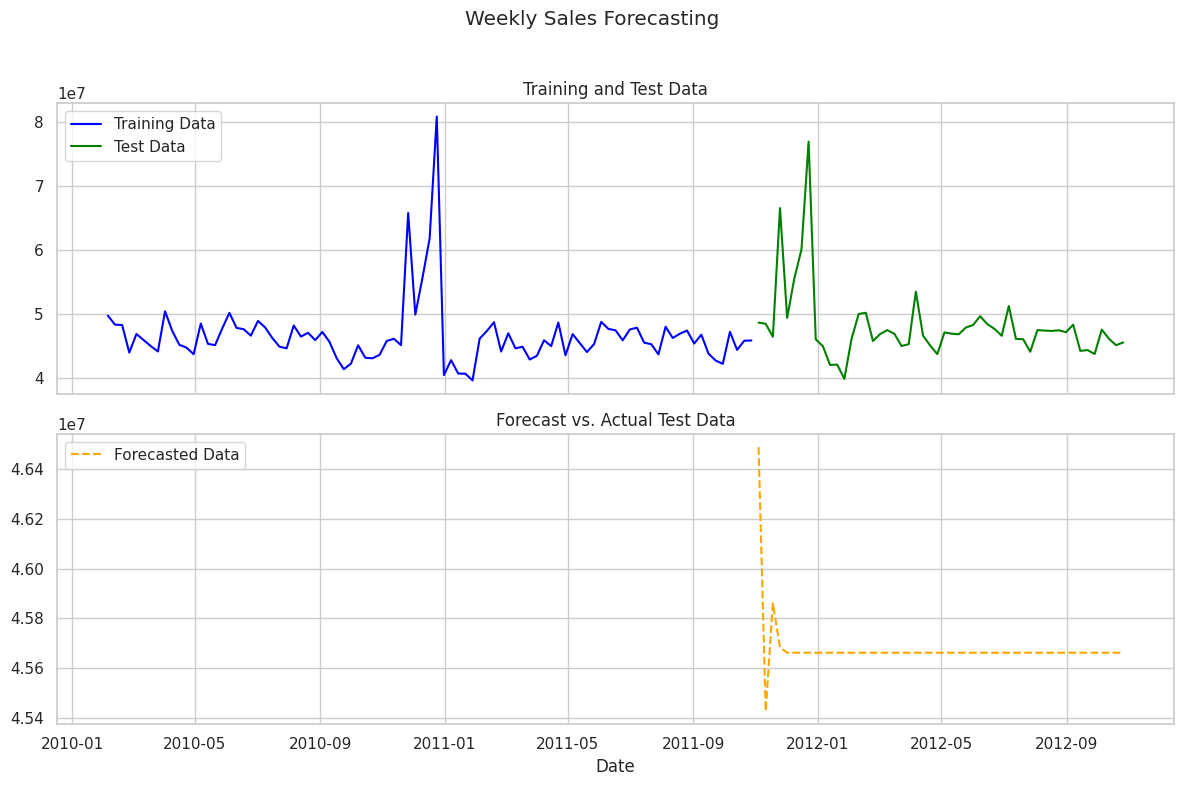

In [218]:
# Forecast for the test period
forecast = best_model.forecast(steps=len(test))

# Plot the training and test data in the upper plot, and forecast vs. actual test data in the lower plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Upper subplot for training and test data
ax1.plot(train.index, train, label='Training Data', color='blue')
ax1.plot(test.index, test, label='Test Data', color='green')
ax1.set_title('Training and Test Data')
ax1.legend(loc='upper left')

# Lower subplot for forecast vs. actual test data
# ax2.plot(test.index, test, label='Actual Test Data', color='green')
ax2.plot(test.index, forecast, label='Forecasted Data', color='orange', linestyle='--')
ax2.set_title('Forecast vs. Actual Test Data')
ax2.legend(loc='upper left')

# Set common labels
fig.suptitle('Weekly Sales Forecasting')
plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()